In [1]:
import os
import sys
import json
import itertools
import matplotlib.pyplot as plt

from collections import Counter
from datasets import Dataset, DatasetDict

## Load Dataset.

In [2]:
def json_to_dataset(dataset_path):
    """
    Load JSON file into HuggingFace Dataset.
    """
    with open(dataset_path, "r", encoding="utf-8") as f:
        dataset = json.load(f)
    dataset = Dataset.from_list(dataset)
    return dataset


# Create a unified dataset
train_path = "../input/samsum/train.json"
valid_path = "../input/samsum/val.json"
test_path = "../input/samsum/test.json"

train_dataset = json_to_dataset(train_path)
valid_dataset = json_to_dataset(valid_path)
test_dataset = json_to_dataset(test_path)

dataset = DatasetDict({
    "train": train_dataset,
    "valid": valid_dataset,
    "test": test_dataset
})

## Analyze Dataset.

In [3]:
# Explore dataset structure
print("Train Dataset Size:", len(dataset["train"]))
print("Valid Dataset Size:", len(dataset["valid"]))
print("Test Dataset Size:", len(dataset["test"]))

# Display dataset sample
print("\nDataset Sample:")
print("Id:", dataset["train"][0]["id"])
print("Summary:", dataset["train"][0]["summary"])
print("\nDialogue:\n" + dataset["train"][0]["dialogue"])

Train Dataset Size: 14732
Valid Dataset Size: 818
Test Dataset Size: 819

Dataset Sample:
Id: 13818513
Summary: Amanda baked cookies and will bring Jerry some tomorrow.

Dialogue:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)


In [4]:
def analyze_lengths(dataset, dataset_label):
    """
    Analyze text data lengths.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    print(f"Analyze lengths for '{dataset_label}':")
    print(f"- Dialogues: Mean={sum(dialogue_lengths) / len(dialogue_lengths):.2f}, Max={max(dialogue_lengths)}, Min={min(dialogue_lengths)}")
    print(f"- Summaries: Mean={sum(summary_lengths) / len(summary_lengths):.2f}, Max={max(summary_lengths)}, Min={min(summary_lengths)}\n")
    return

# Analyze lengths
analyze_lengths(dataset, "train")
analyze_lengths(dataset, "valid")
analyze_lengths(dataset, "test")

Analyze lengths for 'train':
- Dialogues: Mean=93.79, Max=803, Min=0
- Summaries: Mean=20.32, Max=64, Min=1

Analyze lengths for 'valid':
- Dialogues: Mean=91.64, Max=540, Min=10
- Summaries: Mean=20.28, Max=59, Min=3

Analyze lengths for 'test':
- Dialogues: Mean=95.51, Max=516, Min=9
- Summaries: Mean=20.02, Max=58, Min=3



In [5]:
def find_texts_below_length(dataset, dataset_label, max_length):
    """
    Find texts with lengths below or equal to a specified value.
    """
    data = dataset[dataset_label]
    ids = data["id"]
    summaries = data["summary"]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Identify texts
    short_dialogues = [(ids[i], dialogues[i], summaries[i]) for i, length in enumerate(dialogue_lengths) if length <= max_length]
    short_summaries = [(ids[i], summaries[i], dialogues[i]) for i, length in enumerate(summary_lengths) if length <= max_length]
    # Display results
    print(f"Analyze texts with length <= {max_length} for '{dataset_label}':")
    print("=== Dialogues ===")
    for i, (id, dialogue, summary) in enumerate(short_dialogues):
        print(f"{i+1}. (id {id}) Dialogue ({len(dialogue.split())} words):\n{dialogue}")
        print(f"   Associated Summary ({len(summary.split())} words): {summary}\n")
    print("\n=== Summaries ===")
    for i, (id, summary, dialogue) in enumerate(short_summaries):
        print(f"{i+1}. (id {id}) Summary ({len(summary.split())} words): {summary}")
        print(f"   Associated Dialogue ({len(dialogue.split())} words):\n{dialogue}\n")
    return


# Analyze extreme texts (min & max)
find_texts_below_length(dataset, "train", 2)
find_texts_below_length(dataset, "valid", 2)
find_texts_below_length(dataset, "test", 2)

Analyze texts with length <= 2 for 'train':
=== Dialogues ===
1. (id 13828807) Dialogue (0 words):

   Associated Summary (6 words): problem with visualization of the content


=== Summaries ===
1. (id 13810635) Summary (1 words): test
   Associated Dialogue (65 words):
Rivka: How do you like your neighborhood
Coen: I dont like them much
Rivka: Why is that so?
Coen: They are so mean like they play songs at loud music even late night
Rivka: Maybe you can request them to slow down the volume
Coen: We have tried to do so
Rivka: Why dont you ask your mother to visit their place?
Coen: I will

2. (id 13727708) Summary (1 words): yyy
   Associated Dialogue (30 words):
Sue: WOW! you look awesome in this picture
Joanna: The dress covered it up
Sue: Are you coming back?
Joanna: Yeah, I'm in a hurry
Joanna: Speak to you later!

3. (id 13864563) Summary (2 words): Manchester won.
   Associated Dialogue (9 words):
Parker: I told you 
Laila: What?
Wisner: Manchester won... 

4. (id 13681708) Summar

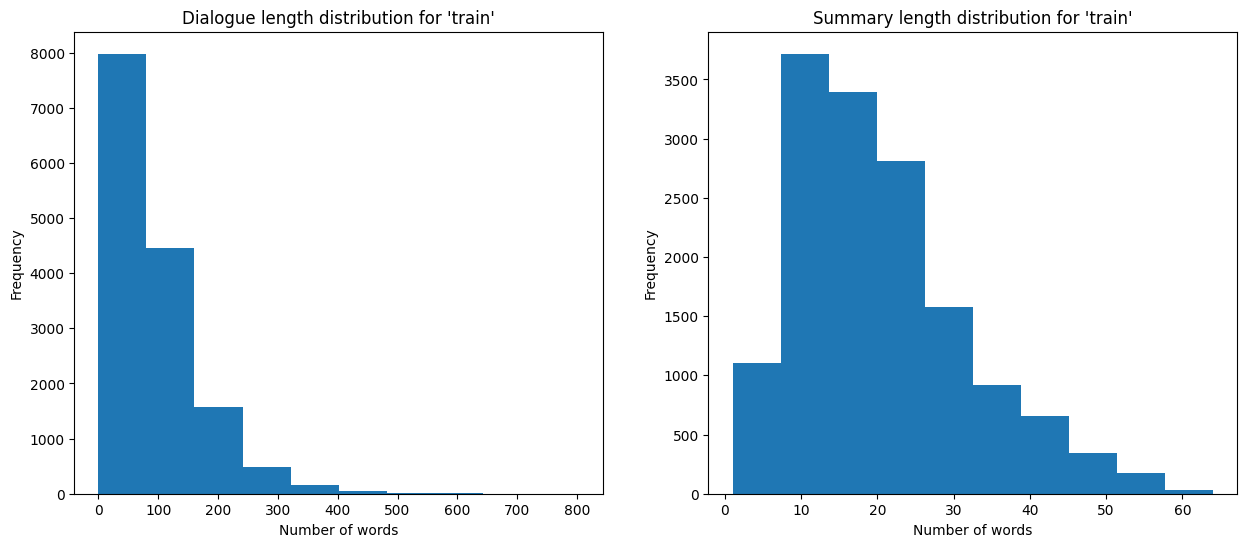

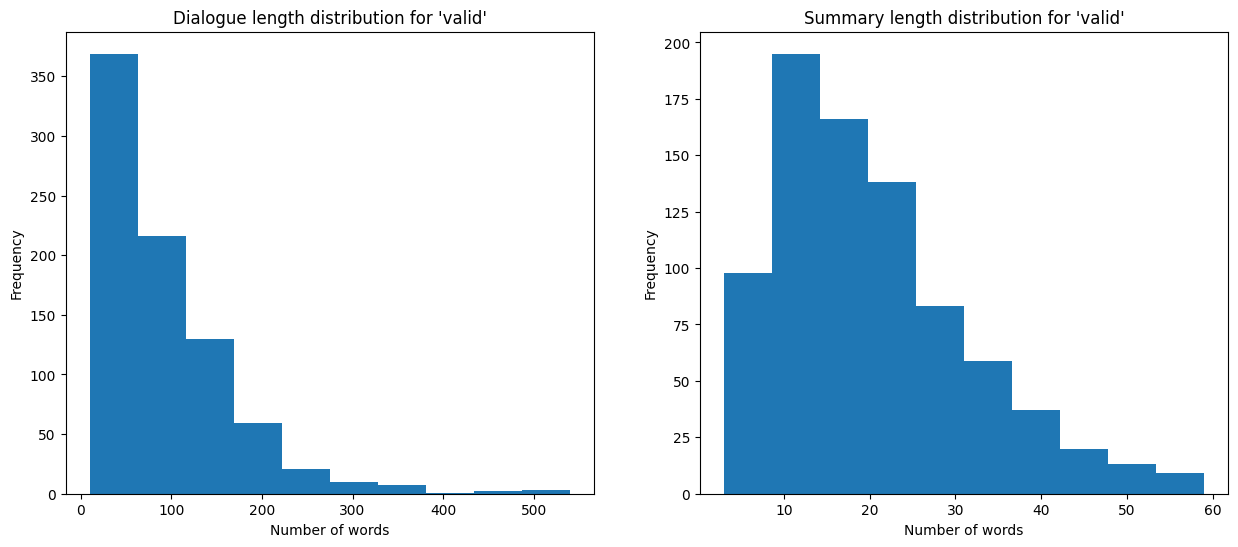

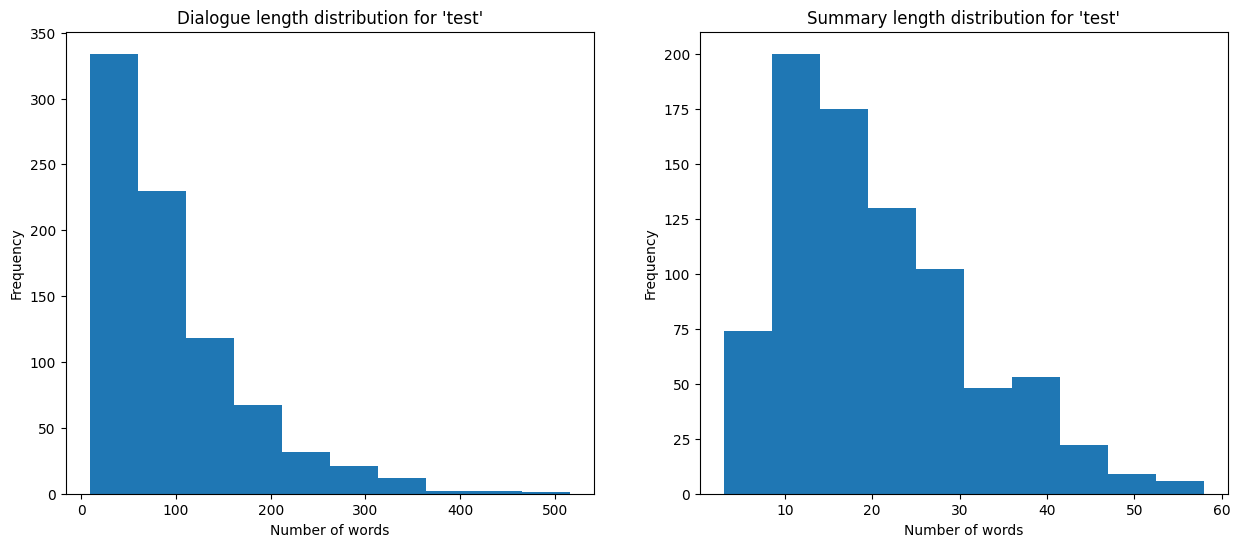

In [6]:
def plot_length_distribution(dataset, dataset_label):
    """
    Plot text lengths distribution.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_lengths = [len(dialogue.split()) for dialogue in dialogues]
    summary_lengths = [len(summary.split()) for summary in summaries]
    # Plot dialogue length distribution
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.hist(dialogue_lengths)
    plt.title(f"Dialogue length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    # Plot summary length distribution
    plt.subplot(1, 2, 2)
    plt.hist(summary_lengths)
    plt.title(f"Summary length distribution for '{dataset_label}'")
    plt.xlabel("Number of words")
    plt.ylabel("Frequency")
    plt.show()
    return

# Graficar para diálogos y resúmenes
plot_length_distribution(dataset, "train")
plot_length_distribution(dataset, "valid")
plot_length_distribution(dataset, "test")

In [11]:
def analyze_word_frequency(dataset, dataset_label, top_n=10):
    """
    Count most common words.
    """
    data = dataset[dataset_label]
    dialogues = data["dialogue"]
    summaries = data["summary"]
    dialogue_words = list(itertools.chain(*[sample.split() for sample in dialogues]))    
    summary_words = list(itertools.chain(*[sample.split() for sample in summaries]))
    # Get word frequency
    dialogue_word_counts = Counter(dialogue_words)
    summary_word_counts = Counter(summary_words)
    dialogue_most_common = dialogue_word_counts.most_common(top_n)
    summary_most_common = summary_word_counts.most_common(top_n)
    print(f"Analyze word frequency for '{dataset_label}':")
    print("=== Dialogues ===")
    for word, count in dialogue_most_common:
        print(f"{word}: {count}")
    print("\n=== Summaries ===")
    for word, count in summary_most_common:
        print(f"{word}: {count}")
    print()
    return


# Analyze most common words
analyze_word_frequency(dataset, "train", 10)
analyze_word_frequency(dataset, "valid", 10)
analyze_word_frequency(dataset, "test", 10)

Analyze word frequency for 'train':
=== Dialogues ===
I: 37592
you: 31617
the: 29897
to: 28658
a: 21640
and: 15311
it: 14302
for: 11546
in: 10723
of: 10267

=== Summaries ===
to: 11567
and: 10138
the: 9871
a: 7366
is: 6811
will: 6653
for: 4638
in: 4042
at: 3693
her: 3096

Analyze word frequency for 'valid':
=== Dialogues ===
I: 2008
you: 1672
the: 1619
to: 1489
a: 1157
and: 807
it: 763
for: 658
in: 602
is: 560

=== Summaries ===
to: 650
and: 570
the: 562
a: 413
is: 392
will: 334
for: 277
in: 241
at: 227
her: 198

Analyze word frequency for 'test':
=== Dialogues ===
I: 2135
you: 1715
the: 1680
to: 1552
a: 1230
and: 900
it: 756
for: 638
in: 590
is: 577

=== Summaries ===
to: 662
and: 555
the: 513
a: 417
will: 372
is: 364
in: 217
for: 204
at: 202
her: 180

